In [1]:
import os
import ast
import sys
src_dir = os.path.join('..', 'src')
sys.path.append(os.path.abspath(src_dir))
import numpy as np
import tensorflow as tf

from embbeding import get_embbeding_layer
from vectorizer import load_vectorizer
from data import get_dataset
from dataprep import split, preprocess

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
data = get_dataset()
data.is_oc = data.is_oc.astype(np.float32)
data.is_self = data.is_self.astype(np.float32)
train, test = split(data)
train, test = preprocess(train, test)

../../data/datasets/dataset_1.00b.csv
Removed 705 rows while filtering 0.98 quantile of words_in_body_count
Removed 687 rows while filtering 0.98 quantile of title_capital_letters_count
Removed 682 rows while filtering 0.98 quantile of body_capital_letters_count
Original rows: 35017, rows after preprocessing: 32943
Dataframe reduced by: 6.30%


In [3]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("score")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    
    return ds
    
train_ds = dataframe_to_dataset(train)
validation_ds = dataframe_to_dataset(test)

In [4]:
train_ds = train_ds.batch(32)
validation_ds = validation_ds.batch(32)

In [5]:
def encode_text_feature(feature, name, dataset):
    vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=100, output_mode='int')

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    
    vectorizer.adapt(feature_ds)
    encoded_feature = vectorizer(feature)
    
    return encoded_feature

In [30]:
def embbed_vectorized_text(feature):
    return layers.Embedding(20000, 64)(feature)

def add_lstm(feature, out_dim=16, return_sequences=False):
    return layers.Bidirectional(layers.LSTM(out_dim, return_sequences=return_sequences))(feature)

In [35]:
def text_input(columns):
    return [keras.Input(shape=(1,), name=column, dtype=tf.string) for column in columns]

def numerical_input(columns):
    return [keras.Input(shape=(1,), name=column, dtype="float64") for column in columns]

def vectorize_inputs(input_layers, columns, dataset):
    result = []
    for i, layer in enumerate(input_layers):
        result.append(encode_text_feature(layer, columns[i], dataset))
        
    return result

def embedding_layers(in_layers):
    return [embbed_vectorized_text(layer) for layer in in_layers]

def add_lstm_layers(in_layers, out_dim=16, return_sequences=False):
    return [add_lstm(layer, out_dim, return_sequences) for layer in in_layers]

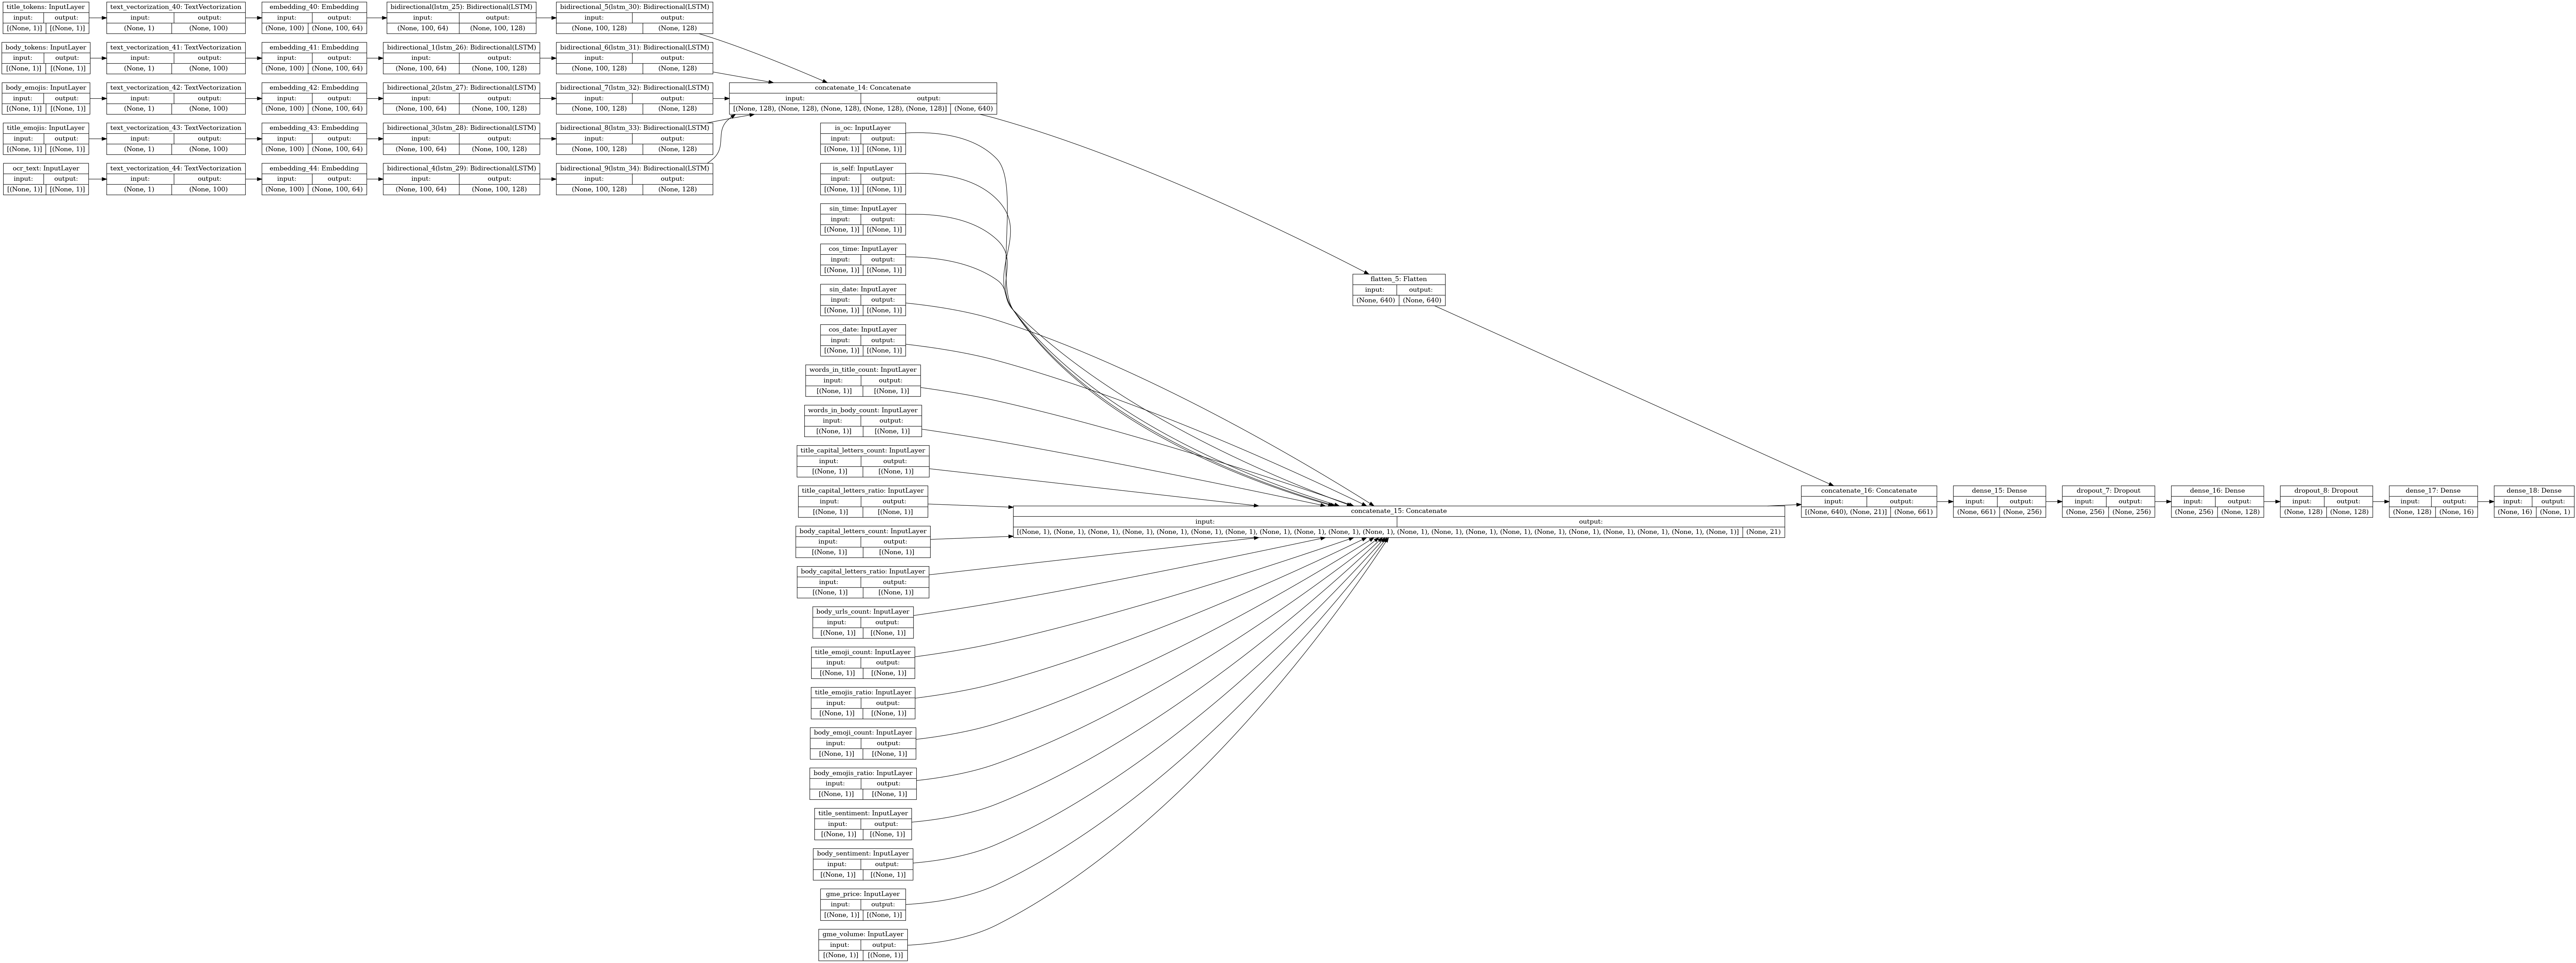

In [36]:
text_columns = train.iloc[:, 1:6].columns
numerical_columns = train.iloc[:, 6:].columns

text_inputs = text_input(text_columns)
numerical_inputs = numerical_input(numerical_columns)
all_inputs = text_inputs + numerical_inputs

vectorized_text_layers = vectorize_inputs(text_inputs, text_columns, train_ds)
embedded_text_layers = embedding_layers(vectorized_text_layers)

lstm = add_lstm_layers(embedded_text_layers, 64, True)
lstm = add_lstm_layers(lstm, 64)

text = layers.concatenate(lstm)

numerical = layers.concatenate(numerical_inputs)

# y = layers.LSTM(128, return_sequences=True)(text)
# y = layers.LSTM(32)(y)

y = layers.Flatten()(text)

# x = layers.Dense(128, activation="relu")(numerical)
# x = layers.Dropout(0.5)(x)

# all_ = layers.concatenate([y, x])
all_ = layers.concatenate([y, numerical])
z = layers.Dense(256, activation="relu")(all_)
z = layers.Dropout(0.5)(z)
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.2)(z)
z = layers.Dense(16, activation="relu")(z)

output = layers.Dense(1, activation="linear")(z)
model = keras.Model(all_inputs, output)
model.compile("adam", loss="mean_absolute_error", metrics=["mean_absolute_percentage_error"])
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [28]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
#     tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_format='tf'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [37]:
model.fit(train_ds, epochs=200, callbacks=my_callbacks, validation_data=validation_ds)

Epoch 1/200
1030/1030 [==============================] - 336s 309ms/step - loss: 1043.9617 - mean_absolute_percentage_error: 1402765070.0179 - val_loss: 1128.9382 - val_mean_absolute_percentage_error: 1518198400.0000
Epoch 2/200
1030/1030 [==============================] - 331s 321ms/step - loss: 1033.4040 - mean_absolute_percentage_error: 1465646745.9166 - val_loss: 1128.8948 - val_mean_absolute_percentage_error: 1260489728.0000
Epoch 3/200
1030/1030 [==============================] - 350s 339ms/step - loss: 1023.7618 - mean_absolute_percentage_error: 1316222609.8778 - val_loss: 1153.0530 - val_mean_absolute_percentage_error: 2895902720.0000
Epoch 4/200
1030/1030 [==============================] - 378s 367ms/step - loss: 1011.6910 - mean_absolute_percentage_error: 1384009778.2813 - val_loss: 1132.3230 - val_mean_absolute_percentage_error: 1128470784.0000
Epoch 5/200
1030/1030 [==============================] - 354s 344ms/step - loss: 993.0014 - mean_absolute_percentage_error: 14451832

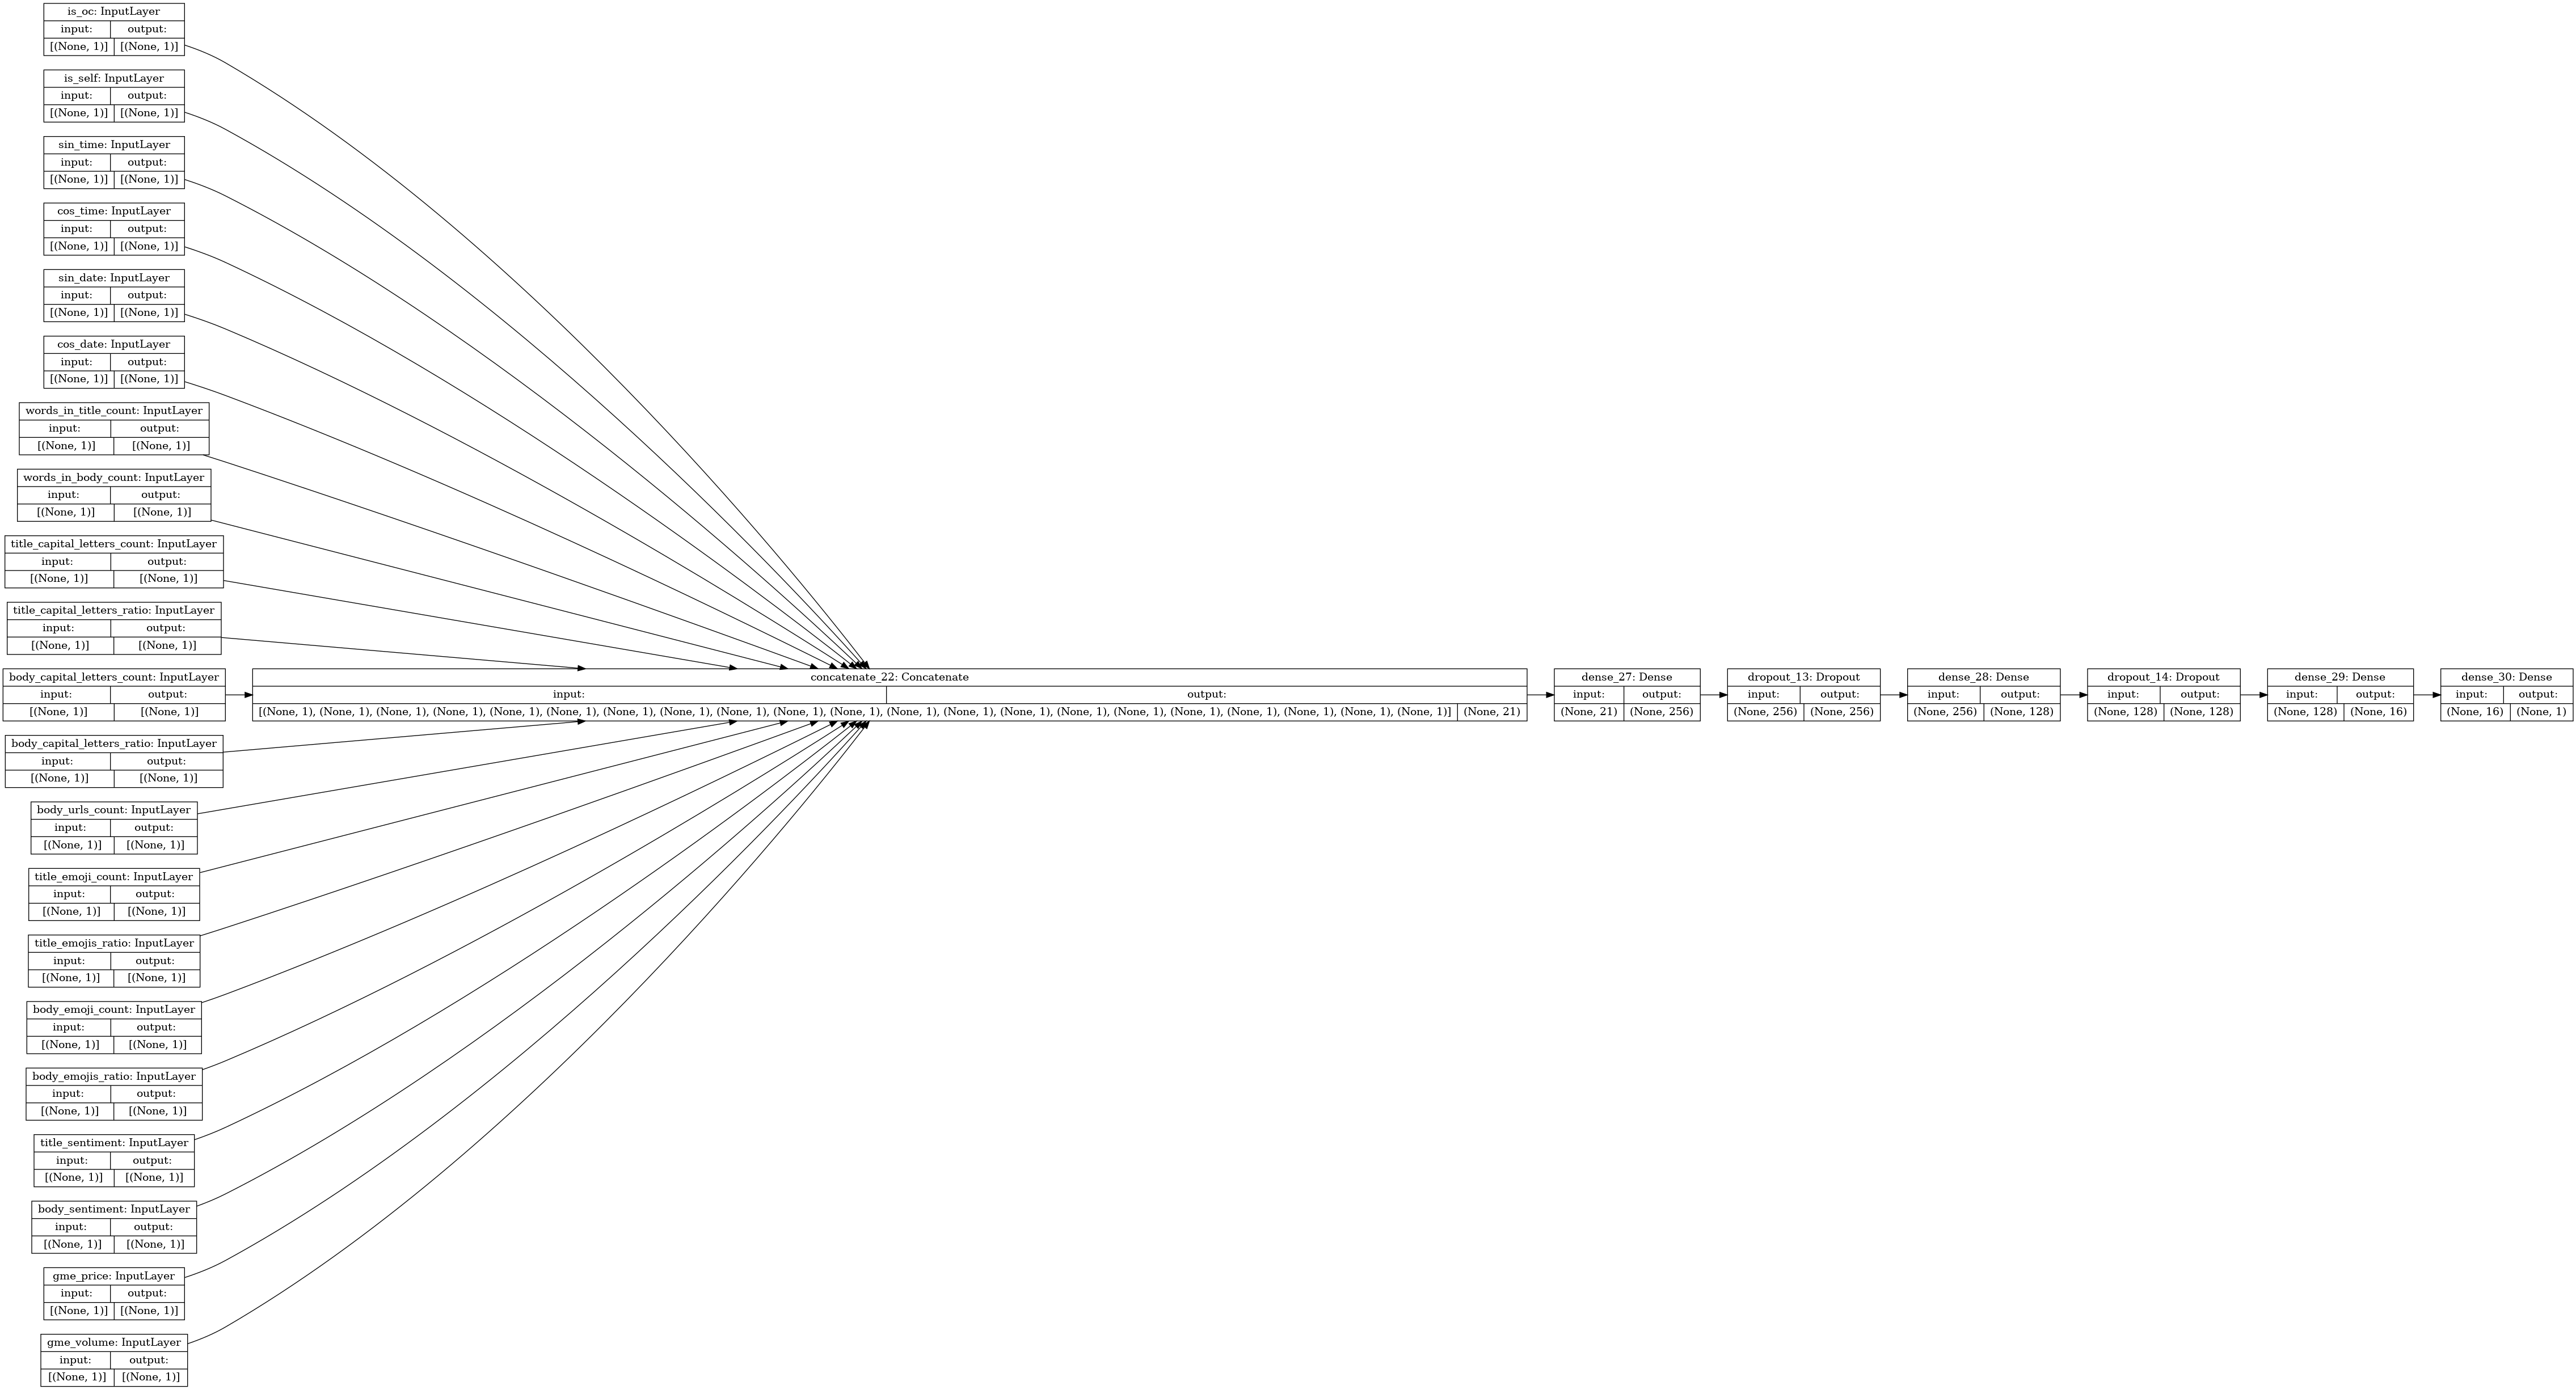

In [41]:
text_columns = train.iloc[:, 1:6].columns
numerical_columns = train.iloc[:, 6:].columns

text_inputs = text_input(text_columns)
numerical_inputs = numerical_input(numerical_columns)
all_inputs = text_inputs + numerical_inputs

vectorized_text_layers = vectorize_inputs(text_inputs, text_columns, train_ds)
embedded_text_layers = embedding_layers(vectorized_text_layers)

lstm = add_lstm_layers(embedded_text_layers, 64, True)
lstm = add_lstm_layers(lstm, 64)

text = layers.concatenate(lstm)

numerical = layers.concatenate(numerical_inputs)

# y = layers.LSTM(128, return_sequences=True)(text)
# y = layers.LSTM(32)(y)

y = layers.Flatten()(text)

# x = layers.Dense(128, activation="relu")(numerical)
# x = layers.Dropout(0.5)(x)

# all_ = layers.concatenate([y, x])
# all_ = layers.concatenate([y, numerical])
z = layers.Dense(256, activation="relu")(numerical)
z = layers.Dropout(0.5)(z)
z = layers.Dense(128, activation="relu")(z)
z = layers.Dropout(0.2)(z)
z = layers.Dense(16, activation="relu")(z)

output = layers.Dense(1, activation="linear")(z)
model = keras.Model(numerical_inputs, output)
model.compile("adam", loss="mean_absolute_error")
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [42]:
model.fit(train_ds, epochs=200, callbacks=my_callbacks, validation_data=validation_ds)

Epoch 1/200


/home/kira/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:592: UserWarning: Input dict contained keys ['title_tokens', 'body_tokens', 'body_emojis', 'title_emojis', 'ocr_text'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1030/1030 [==============================] - 3s 2ms/step - loss: 1042.6373 - val_loss: 1127.2692
Epoch 2/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1033.8038 - val_loss: 1125.3210
Epoch 3/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1031.5232 - val_loss: 1124.3118
Epoch 4/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1030.2034 - val_loss: 1122.4818
Epoch 5/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1029.6571 - val_loss: 1122.6267
Epoch 6/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1028.6955 - val_loss: 1121.7458
Epoch 7/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1027.6903 - val_loss: 1121.0453
Epoch 8/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1027.6310 - val_loss: 1120.1005
Epoch 9/200
1030/1030 [==============================] - 2s 2ms/step - loss: 1027.0908 - val_loss: 1119.4507
Epoch 10/200
1030/1030 [=======